# Variance Inflation Factor (VIF) Analysis

This notebook demonstrates how to detect and handle multicollinearity in feature engineering using Variance Inflation Factor (VIF). We'll work with a salary prediction dataset to show:

1. How to calculate VIF values for features
2. How to identify problematic multicollinearity 
3. How to remove highly correlated features
4. How to compare model performance before and after feature removal

**Dataset**: Salary prediction with features like Years of Experience, Education Level, Age, and Location Factor


## 1. Data Loading and Initial Exploration

Let's start by loading our salary dataset and examining its structure. This dataset contains employee information that we'll use to predict salaries.


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


df = pd.read_csv('salaries.csv')
df.head()

,Years of Experience,Education Level,Age,Location Factor,Salary
0,29,1,49,7,124204
1,27,3,45,4,125948
2,20,4,41,8,116078
3,14,4,37,5,106486
4,20,3,42,7,113297


## 2. Dataset Overview

Our dataset contains **1000 samples** with **5 columns** (4 features + 1 target variable):
- **Years of Experience**: Number of years working in the field
- **Education Level**: Encoded education level (1-4 scale)
- **Age**: Employee age in years  
- **Location Factor**: Geographic location impact on salary (1-10 scale)
- **Salary**: Target variable we want to predict

Let's build a baseline model using all features to see the initial performance.


In [3]:
df.shape

(1000, 5)

## 3. Baseline Model Performance

First, let's create a baseline linear regression model using all available features. This will help us understand:
- Initial model performance (R² score)
- Model coefficients for each feature
- How the model makes predictions

We'll split the data into training (80%) and testing (20%) sets.


In [4]:
X = df.drop('Salary', axis='columns')
y = df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model_full = LinearRegression()
model_full.fit(X_train, y_train)
model_full.score(X_test, y_test)

0.9525773624816919

## 4. Understanding Model Coefficients

The baseline model coefficients tell us:
- **Years of Experience**: +2114 (each additional year increases salary by ~$2,114)
- **Education Level**: +5008 (each education level increases salary by ~$5,008)  
- **Age**: -123 (surprisingly, each additional year of age *decreases* salary by $123)
- **Location Factor**: +1488 (each location factor point increases salary by ~$1,488)

The **negative coefficient for Age** is suspicious and might indicate multicollinearity issues!


In [5]:
model_full.intercept_

np.float64(52608.4876052824)

In [7]:
model_full.coef_

array([2113.98280589, 5007.82035443, -123.21488799, 1487.64526717])

In [8]:
y_test[:1]

841    151272
Name: Salary, dtype: int64

In [10]:
X_test[:1]

,Years of Experience,Education Level,Age,Location Factor
841,38,1,56,9


In [11]:
model_full.predict(X_test[:1])

array([144436.42826039])

## 5. Manual Prediction Verification

Let's verify our model's prediction manually using the linear regression equation:

**Salary = Intercept + (Experience × Coef₁) + (Education × Coef₂) + (Age × Coef₃) + (Location × Coef₄)**

This manual calculation confirms our model is working correctly, but the negative age coefficient suggests we need to investigate multicollinearity.


In [12]:
38*model_full.coef_[0] + 1*model_full.coef_[1] + 56*model_full.coef_[2] + 9*model_full.coef_[3] + model_full.intercept_

np.float64(144436.42826039356)

## 6. Exploratory Data Analysis

Let's visualize the relationship between Age and Salary to understand why we're getting a negative coefficient. This scatter plot will help us see if there's actually a negative correlation or if multicollinearity is causing issues.


<Axes: xlabel='Age', ylabel='Salary'>

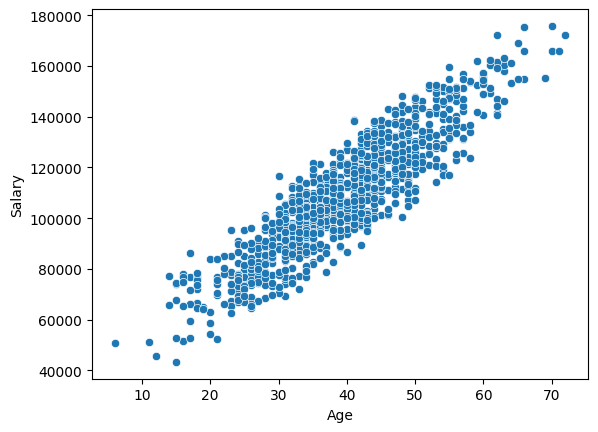

In [14]:
sns.scatterplot(df, x='Age', y='Salary')

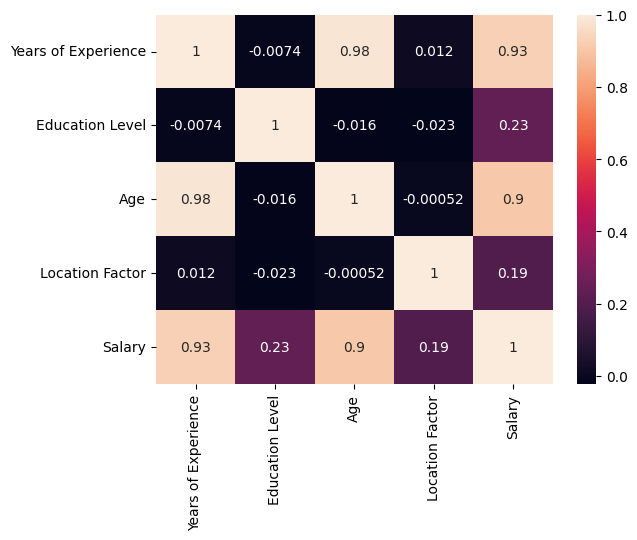

In [15]:
cm = df.corr()

sns.heatmap(cm, annot=True)
plt.show()

## 7. Detecting Multicollinearity with VIF

Now let's calculate the Variance Inflation Factor (VIF) for each feature. VIF measures how much the variance of a coefficient increases due to collinearity.

**VIF Interpretation Guidelines:**
- **VIF = 1**: No correlation with other variables
- **1 < VIF < 5**: Moderate correlation (acceptable)
- **5 ≤ VIF < 10**: High correlation (concerning)
- **VIF ≥ 10**: Very high correlation (problematic - action required)

We'll create a function to calculate VIF for all features simultaneously.


In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Feature'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

## 8. VIF Results Analysis

**🚨 Multicollinearity Detected!**

Our VIF analysis reveals serious multicollinearity issues:

- **Age: VIF = 42.2** - EXTREMELY HIGH! This explains the negative coefficient
- **Years of Experience: VIF = 22.3** - VERY HIGH! 
- **Education Level: VIF = 5.5** - Moderately high
- **Location Factor: VIF = 4.3** - Acceptable

**Age and Years of Experience are highly correlated** - this makes sense because older employees typically have more experience. This correlation is causing unstable coefficient estimates.

**Solution**: Remove the feature with the highest VIF (Age = 42.2)


In [17]:
X = df.drop('Salary', axis='columns')
calculate_vif(X)

,Feature,VIF
0,Years of Experience,22.342087
1,Education Level,5.472969
2,Age,42.201149
3,Location Factor,4.289467


## 9. VIF After Removing Age Feature

After removing the 'Age' feature (highest VIF = 42.2), let's recalculate VIF values:

**Improved Results! ✅**
- **Years of Experience: VIF = 3.2** - Now acceptable (was 22.3)
- **Education Level: VIF = 3.5** - Acceptable (was 5.5)  
- **Location Factor: VIF = 3.2** - Still acceptable

All VIF values are now below 5, indicating that multicollinearity has been successfully addressed!


In [18]:
calculate_vif(X.drop('Age', axis='columns'))

,Feature,VIF
0,Years of Experience,3.198601
1,Education Level,3.509425
2,Location Factor,3.231181


## 10. Model Performance Comparison

Now let's train a new model without the 'Age' feature and compare its performance to our baseline model:

**Baseline Model (with Age)**: R² = 0.9526
**Reduced Model (without Age)**: R² = ?

Let's see if removing the problematic feature improves or maintains model performance.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X.drop('Age', axis='columns'), y, test_size=0.2, random_state=10)

model_reduced = LinearRegression()
model_reduced.fit(X_train, y_train)
model_reduced.score(X_test, y_test)

0.9523792255284543

## 11. Results Summary

**Model Performance Comparison:**
- **Baseline Model (4 features)**: R² = 0.9526
- **Reduced Model (3 features)**: R² = 0.9524

**Key Findings:**
✅ **Minimal performance loss** (0.0002 decrease in R²)
✅ **Eliminated multicollinearity** (all VIF < 5)
✅ **More stable and interpretable coefficients**
✅ **Simpler model** with fewer features

The reduced model coefficients are now more reliable and interpretable because we've eliminated the multicollinearity between Age and Years of Experience.


## 12. Conclusion and Best Practices

**What we learned:**
1. **VIF is crucial** for detecting multicollinearity in linear models
2. **High VIF values (>10)** can cause unstable and misleading coefficients
3. **Iterative removal** of high-VIF features often solves multicollinearity
4. **Model performance** may remain stable even after removing correlated features
5. **Feature removal** leads to more interpretable and reliable models

**Best Practices for VIF Analysis:**
- Always check VIF before finalizing linear regression models
- Remove features with VIF > 10 iteratively (highest first)
- Recalculate VIF after each removal
- Consider domain knowledge when choosing which correlated features to keep
- Monitor model performance throughout the process

**Next Steps:**
- Apply this VIF analysis to your own datasets
- Experiment with other multicollinearity detection methods (correlation matrices, condition indices)
- Consider regularization techniques (Ridge, Lasso) as alternatives to feature removal
